In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os

# Define file paths
DATASET_PATH = r"E:\TIme series proj\Dataset\AEP_hourly.csv"
OUTPUT_CSV_PATH = r"E:\TIme series proj\Dataset\cleaned_dataset.csv"
PLOT_DIR = r"E:\TIme series proj\Dataset"
PICKLE_DIR = r"E:\TIme series proj\files"

# Ensure output directories exist
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(PICKLE_DIR, exist_ok=True)

In [2]:
print("Section 1: Loading and Inspecting Data")
# Load the dataset
try:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {DATASET_PATH}")
    exit()

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display basic info (data types, non-null counts)
print("\nDataset Info:")
print(df.info())

# Display summary statistics
print("\nInitial Summary Statistics:")
print(df.describe())

Section 1: Loading and Inspecting Data
Dataset loaded successfully!

First 5 rows of the dataset:
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None

Initial Summary Statistics:
              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000


In [ ]:
Inferences:

1. The dataset is large (121,273 hourly records, ~14 years from 2004–2018), ideal for time-series analysis.
2. No immediate red flags
3. The max (25,695 MW) is high compared to the 75th percentile (17,200 MW). This could indicate outliers.

In [3]:
# --- Section 2: Data Cleaning ---
print("\nSection 2: Data Cleaning")
# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Check for invalid datetime entries
invalid_dates = df[df['Datetime'].isna()]
if not invalid_dates.empty:
    print(f"Warning: {len(invalid_dates)} rows with invalid dates found!")
    print(invalid_dates)
else:
    print("No invalid datetime entries found.")

# Set Datetime as index and sort chronologically
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values in 'AEP_MW' (forward fill approach)
if df['AEP_MW'].isnull().sum() > 0:
    print("Filling missing AEP_MW values with forward fill.")
    df['AEP_MW'].fillna(method='ffill', inplace=True)
else:
    print("No missing values in AEP_MW to fill.")

# Check for duplicates in the index (duplicate timestamps)
duplicates = df.index.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate timestamps. Keeping first occurrence.")
    df = df[~df.index.duplicated(keep='first')]
else:
    print("No duplicate timestamps found.")

# Check for outliers using a simple rule (beyond 3 standard deviations, 3 sigma rule)
mean_mw = df['AEP_MW'].mean()
std_mw = df['AEP_MW'].std()
outliers = df[(df['AEP_MW'] > mean_mw + 3*std_mw) | (df['AEP_MW'] < mean_mw - 3*std_mw)]
print(f"\nOutliers Detected ({len(outliers)} rows):")
print(outliers.head() if not outliers.empty else "No outliers detected.")

print("Outliers noted but not removed for initial analysis.")


Section 2: Data Cleaning
No invalid datetime entries found.

Missing Values:
AEP_MW    0
dtype: int64
No missing values in AEP_MW to fill.
Found 4 duplicate timestamps. Keeping first occurrence.

Outliers Detected (259 rows):
                      AEP_MW
Datetime                    
2005-07-25 14:00:00  23558.0
2005-07-25 15:00:00  23741.0
2005-07-26 14:00:00  23470.0
2005-07-26 15:00:00  23860.0
2005-07-26 16:00:00  24015.0
Outliers noted but not removed for initial analysis.


In [ ]:
Inferences:
1. Outliers (259): Significant but not excessive. They align with expected patterns (summer peaks)

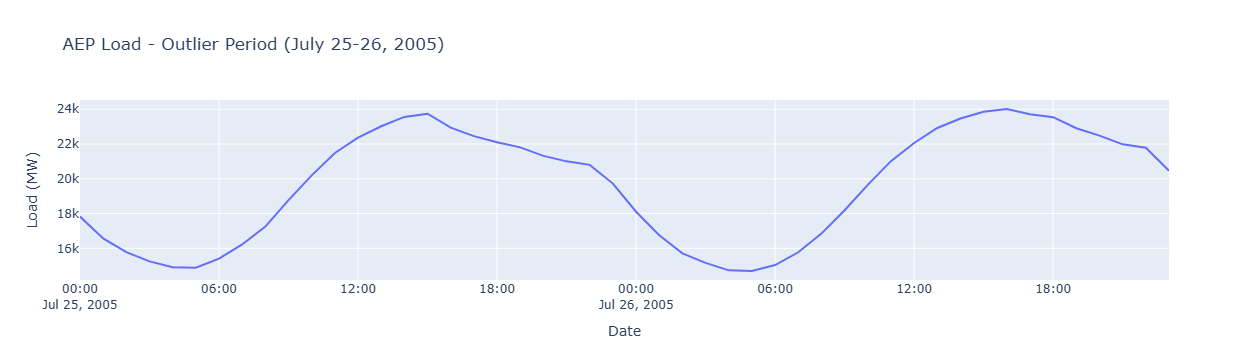

In [9]:
# Plot: Zoom into outlier period (July 25-26, 2005)
outlier_data = df['2005-07-25':'2005-07-26'].reset_index()
fig4 = px.line(outlier_data, x='Datetime', y='AEP_MW', title='AEP Load - Outlier Period (July 25-26, 2005)',
               labels={'AEP_MW': 'Load (MW)', 'Datetime': 'Date'})
fig4.update_layout(showlegend=True)
outlier_plot_html = os.path.join(PLOT_DIR, 'outlier_july_2005.html')
fig4.write_html(outlier_plot_html)

fig4.show()

In [ ]:
Inference: The electricity load exhibits clear seasonal patterns, 
with higher peaks in summer (e.g., 2005, 2010) and winter, likely due to increased demand from air conditioning and heating, 
and lower loads in spring/fall, indicating milder weather conditions.

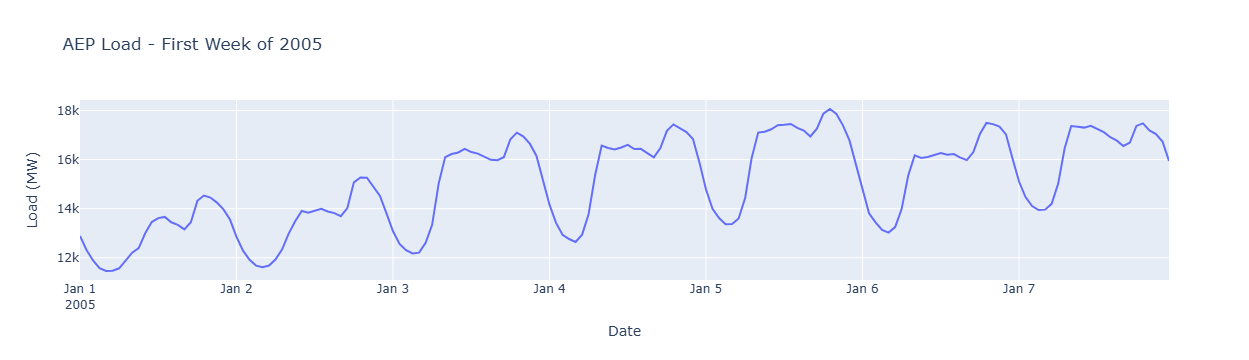

In [5]:
# Plot 2: One week of data (first week of 2005)
week_data = df['2005-01-01':'2005-01-07'].reset_index()
fig2 = px.line(week_data, x='Datetime', y='AEP_MW', title='AEP Load - First Week of 2005',
               labels={'AEP_MW': 'Load (MW)', 'Datetime': 'Date'})
fig2.update_layout(showlegend=True)
week_plot_html = os.path.join(PLOT_DIR, 'week_plot.html')
fig2.write_html(week_plot_html)

fig2.show()

In [ ]:
Inference: Daily load cycles show peaks around 6–7 PM and lows around 3–5 AM, 
suggesting higher residential and commercial usage in the evening and reduced demand at night, 
consistent with typical human activity patterns.

Monthly plot saved as HTML at: E:\TIme series proj\Dataset\month_plot.html


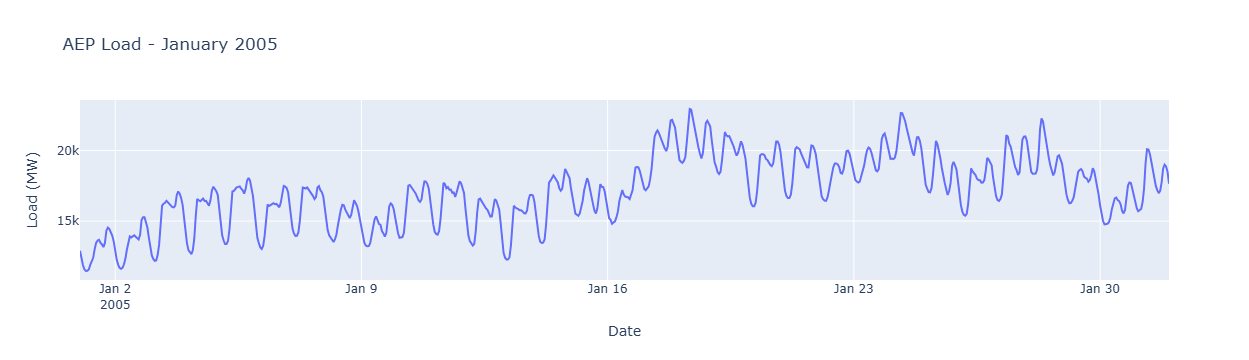

In [6]:
# Plot 3: One month of data (January 2005)
month_data = df['2005-01-01':'2005-01-31'].reset_index()
fig3 = px.line(month_data, x='Datetime', y='AEP_MW', title='AEP Load - January 2005',
               labels={'AEP_MW': 'Load (MW)', 'Datetime': 'Date'})
fig3.update_layout(showlegend=True)
month_plot_html = os.path.join(PLOT_DIR, 'month_plot.html')
fig3.write_html(month_plot_html)

print(f"Monthly plot saved as HTML at: {month_plot_html}")
fig3.show()

In [ ]:
Inference: The load follows a consistent daily cycle with peaks around 6–7 PM, and a mid-month spike (e.g., Jan 15–20) 
suggests a possible cold snap or increased industrial activity,
driving higher demand in mid-January.

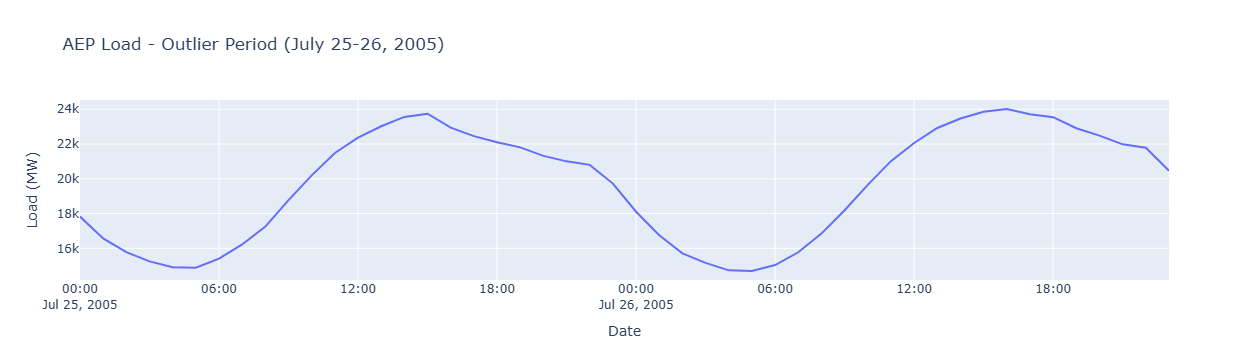

In [7]:
# Plot: Zoom into outlier period (July 25-26, 2005)
outlier_data = df['2005-07-25':'2005-07-26'].reset_index()
fig4 = px.line(outlier_data, x='Datetime', y='AEP_MW', title='AEP Load - Outlier Period (July 25-26, 2005)',
               labels={'AEP_MW': 'Load (MW)', 'Datetime': 'Date'})
fig4.update_layout(showlegend=True)
outlier_plot_html = os.path.join(PLOT_DIR, 'outlier_july_2005.html')
fig4.write_html(outlier_plot_html)

fig4.show()

In [ ]:
Inference: The sharp peaks at 14:00–16:00 (reaching ~24k MW) indicate a significant demand surge,
likely due to a heatwave, as summer afternoons typically see high air conditioning usage, 
confirming the outliers as real events.

In [8]:
# --- Section 4: Save Cleaned Dataset ---
print("\nSection 4: Save Cleaned Dataset")
# Save the cleaned dataset as CSV
df.to_csv(OUTPUT_CSV_PATH)
print(f"Cleaned dataset saved at: {OUTPUT_CSV_PATH}")

# Save as pickle for faster loading later
pickle_path = os.path.join(PICKLE_DIR, 'cleaned_dataset.pkl')
df.to_pickle(pickle_path)
print(f"Cleaned dataset also saved as pickle at: {pickle_path}")


Section 4: Save Cleaned Dataset
Cleaned dataset saved at: E:\TIme series proj\Dataset\cleaned_dataset.csv
Cleaned dataset also saved as pickle at: E:\TIme series proj\files\cleaned_dataset.pkl
